In [1]:
%load_ext autoreload
%autoreload 2
import queue
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('./')
from simulator import simulator
from tqdm import tqdm
random.seed(10)
from curve import get_traffic_curve
from topology import get_topology

# Traffic Curve Lookup Table

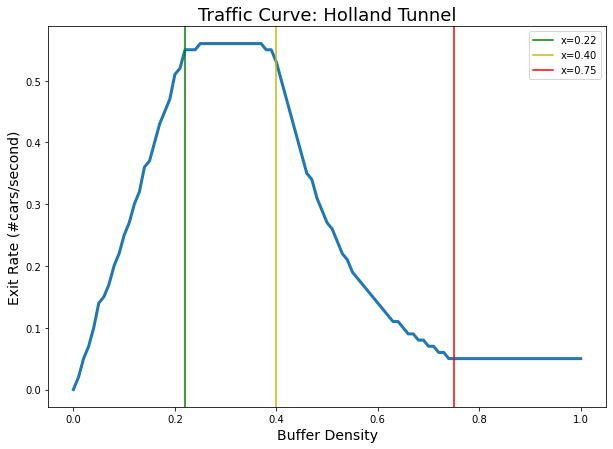

In [2]:
curve = get_traffic_curve()

plt.figure(figsize=(10,7))
plt.xlabel('Buffer Density',size=14)
plt.ylabel('Exit Rate (#cars/second)',size=14)
plt.title('Traffic Curve: Holland Tunnel',size=18)
plt.plot(curve[:,0],curve[:,1],lw=3)
plt.axvline(0.22,c='g',label='x=0.22')
plt.axvline(0.40,c='y', label='x=0.40')
plt.axvline(0.75,c='r', label='x=0.75')
plt.legend()

# Simulator

In [3]:
# class simulator:
#     def __init__(self, edges, lengths, input_edges, next_edge, curve, merges):
#         self.edges = edges
#         self.lengths = lengths
#         self.input_edges = input_edges
#         self.next_edge = next_edge
#         self.curve = curve
#         self.merges = merges
#         self.time = 0
#         self.throughput = []
#         self.buffers = {}
#         self.edge_inputs = {}
#         self.edge_outputs = {}
#         self.eligible = {}
#         for edge in self.edges:
#             self.buffers[edge] = queue.Queue(int(self.lengths[edge]/4))
#             self.edge_inputs[edge] = 0
#             self.edge_outputs[edge] = 0
#             self.eligible[edge] = 0
    
#     def iteration_nosignal(self,input_rate):
#         self.time = self.time + 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             if(self.eligible[edge]):
#                 self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                 if(self.edge_outputs[edge]>=1):
#                     _ = self.buffers[edge].get()
#                     self.edge_outputs[edge] -= 1
#                     next_edge = random.choice(self.next_edge[edge])
#                     if(next_edge is not None):
#                         b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                         self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                    timeout=0.1)
#                     else:
#                         self.throughput.append(self.time)
#             if edge in self.input_edges:
#                 self.edge_inputs[edge] += input_rate[edge]
#                 if(self.edge_inputs[edge]>=1):
#                     self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                     self.edge_inputs[edge] -= 1    
    
#     def iter_merge_equisignal(self,in_edges,out_edge):
#         schedule = {i:in_edges[i] for i in range(len(in_edges))}
#         for edge in in_edges+[out_edge]:
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             scheduled_edge = schedule[(self.time//10)%len(in_edges)]
#             if(self.eligible[edge]):
#                 if(edge in in_edges):
#                     if(edge==scheduled_edge):
#                         self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                         if(self.edge_outputs[edge]>=1):
#                             _ = self.buffers[edge].get()
#                             self.edge_outputs[edge] -= 1
#                             b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
#                             self.buffers[out_edge].put((self.time,self.time+(self.lengths[out_edge]/self.curve[self.curve[:,0]==b_out][0][2])),\
#                                                        timeout=0.1)
#                 else:
                    
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
    
#     def iteration_equisignal(self,input_rate):
#         self.time = self.time + 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             if edge in self.input_edges:
#                 self.edge_inputs[edge] += input_rate[edge]
#                 if(self.edge_inputs[edge]>=1):
#                     self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                     self.edge_inputs[edge] -= 1
                    
#         all_edges = set(self.edges)
#         union_merge = set()
#         for merge in self.merges:
#             in_edges, out_edge = merge[0], merge[1]
#             self.iter_merge_equisignal(in_edges,out_edge)
#             union_merge = union_merge.union(set(in_edges))
#             union_merge = union_merge.union({out_edge})
#         rem_edges = all_edges - union_merge
#         if(len(rem_edges)):
#             for edge in rem_edges:
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
                    
#     def iter_merge_self_regulate(self,in_edges,out_edge):
#         for edge in in_edges+[out_edge]:
#             if(edge not in in_edges):
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         self.throughput.append(self.time)
#             else:
#                 if(self.eligible[edge]):
#                     b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                     alpha = self.get_alpha(in_edges,out_edge)
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]*min(1,alpha)
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                         self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                    timeout=0.1)
    
    
#     def iteration_self_regulate(self,input_rate):
#         self.time += 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)                             
#             if edge in self.input_edges:
#                     self.edge_inputs[edge] += input_rate[edge]
#                     if(self.edge_inputs[edge]>=1):
#                         self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                         self.edge_inputs[edge] -= 1    
                        
#         all_edges = set(self.edges)
#         union_merge = set()
#         for merge in self.merges:
#             in_edges, out_edge = merge[0], merge[1]
#             self.iter_merge_self_regulate(in_edges,out_edge)
#             union_merge.union(set(in_edges))
#             union_merge.union({out_edge})
#         rem_edges = all_edges - union_merge
#         if(rem_edges is not None):
#             for edge in rem_edges:
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
            
              
#     def get_throughput(self):
#         return(self.throughput)
    
#     def get_alpha(self,in_edges,out_edge):
#         b_lim = 0.33
#         c_lim = self.curve[self.curve[:,0]==b_lim][0][1]
#         b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
#         b_ratio = {}
#         for edge in in_edges:
#             b_ratio[edge] = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
#         factor = 1/sum(b_ratio.values())
#         c_norm = {}
#         for edge in in_edges:
#             b_ratio[edge] = b_ratio[edge]*factor
#             b = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
#             c = self.curve[self.curve[:,0]==b][0][1]
#             c_norm[edge] = c*b_ratio[edge]
        
#         if(sum(b_ratio.values())):
#             if(b_lim-b_out>0):
#                 alpha = (b_lim-b_out+c_lim)/(sum(c_norm.values()))
#             else:
#                 alpha=0
#         else:
#             alpha = 1        
#         return(alpha)
    

# Experiments on Holland Tunnel

In [18]:
def simulate(top_code, base_input_rate, burst_input_rate, i1, i2, i3):

    edges, lengths, input_edges, next_edge, merges = get_topology(top_code)
    
    S = simulator(edges, lengths, input_edges, next_edge, merges, curve)
    try:
        for k in range(i1):
            S.iteration_equisignal(base_input_rate)
        for k in range(i2):
            S.iteration_equisignal(burst_input_rate)
        for k in range(i3):
            S.iteration_equisignal(base_input_rate)
    except:
        pass

    time_arr = np.array(S.get_throughput())
    throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

    S = simulator(edges, lengths, input_edges, next_edge, merges, curve)
    try:
        for k in range(i1):
            S.iteration_self_regulate(base_input_rate)
        for k in range(i2):
            S.iteration_self_regulate(burst_input_rate)
        for k in range(i3):
            S.iteration_self_regulate(base_input_rate)
    except:
        pass
    time_arr = np.array(S.get_throughput())
    throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

    S = simulator(edges, lengths, input_edges, next_edge, merges, curve)
    try:
        for k in range(i1):
            S.iteration_nosignal(base_input_rate)
        for k in range(i2):
            S.iteration_nosignal(burst_input_rate)
        for k in range(i3):
            S.iteration_nosignal(base_input_rate)
    except:
        pass

    time_arr = np.array(S.get_throughput())
    throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')
    
    return(throughput_nosignalling, throughput_equisignalling, throughput_self_regulate)

## Holland Tunnel Manhattan to NJ

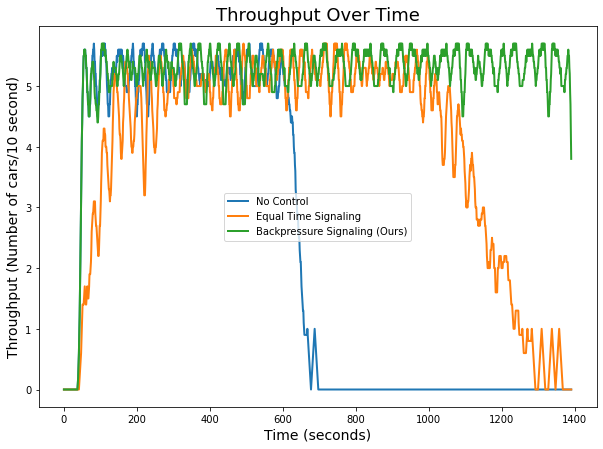

In [19]:
top_code = 'htmnj'

base_input_rate = {'AE':0.132, 'BE':0.132, 'CE':0.132, 'DE':0.132}
v = 0.145
burst_input_rate = {'AE':v, 'BE':v, 'CE':v, 'DE':v}

i1, i2, i3 = 500, 400, 500

throughput_nosignalling, throughput_equisignalling, throughput_self_regulate = simulate(top_code, base_input_rate, burst_input_rate, i1, i2, i3)

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()

# Holland Tunnel NJ to M

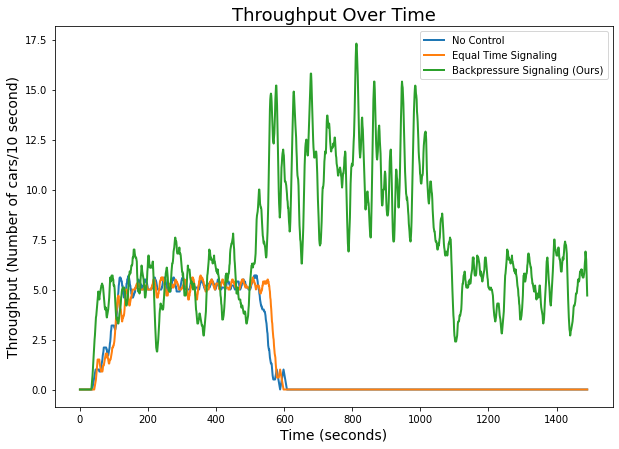

In [28]:
top_code = 'htnjm'

base_input_rate = {'AD':0.088, 'BD':0.088, 'CD':0.088, 'EF':0.088, 'GH':0.088, 'IJ':0.088}
v=0.19
burst_input_rate = {'AD':v, 'BD':v, 'CD':v, 'EF':v, 'GH':v, 'IJ':v}

i1, i2, i3 = 500, 500, 500

throughput_nosignalling, throughput_equisignalling, throughput_self_regulate = simulate(top_code, base_input_rate, burst_input_rate, i1, i2, i3)

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()

# Nairobi Intersection

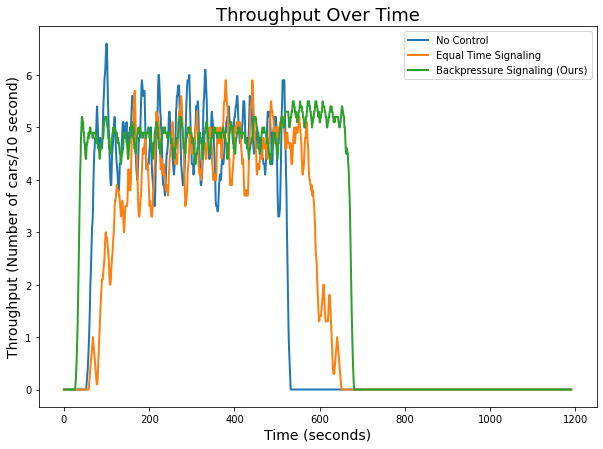

In [21]:
top_code = 'rrlh'

base_input_rate = {'AE':0.120, 'BE':0.120, 'CE':0.120, 'DE':0.120}
v = 0.3
burst_input_rate = {'AE':v, 'BE':v, 'CE':v, 'DE':v}

i1, i2, i3 = 500, 200, 500

throughput_nosignalling, throughput_equisignalling, throughput_self_regulate = simulate(top_code, base_input_rate, burst_input_rate, i1, i2, i3)

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()